In addition to fitting the redshift, we can learn much more from DESI spectra. For example, we can infer the physical properties of galaxies from fitting the continuum of galaxy spectra with stellar population synthesis models.

# Stellar Population Synthesis (SPS) models
In SPS models, galaxies are treated as composite stellar populations (CSPs). CSPs are composed of simple stellar populations (SSPs) whose range of ages given by their SFHs and have a range of metallicities. A standard way of calculating the CSP spectrum is

<img src="csp.png" width="500">

Here SFR(t) is the star formation rate, P(Z,t) is the metallicity distribution function, and f_SSP is the simple stellar population spectrum. f_SSP is calculated from isochrones, stellar spectral libraries, and the initial mass function. For a review on SPS models see [Conroy (2013)](https://ui.adsabs.harvard.edu/abs/2013ARA%26A..51..393C/abstract)

For our purposes, we'll assume that the SSP spectra are fixed and not worry about the different stellar libraries and IMFs. We will also assume that stellar population of age t is a SSP with the same metallicity. So we can simplify the equation above to: 

<img src="csp_simple.png" width="400">

In practice, we model a galaxy as a sum of SSPs with different age and metallicity. This means that we can model the galaxy spectra based on the SFH and ZH. Conversely, we can infer the SFH and ZH of a galaxy from its spectra!

In [1]:
# lets install the python package `provabgs`, a python package for generating the PRObabilistic Value-Added BGS (PROVABGS)
!pip install git+https://github.com/changhoonhahn/provabgs.git --upgrade --user

  Cloning https://github.com/changhoonhahn/provabgs.git to /tmp/pip-req-build-4eyus6h4
  Running command git clone -q https://github.com/changhoonhahn/provabgs.git /tmp/pip-req-build-4eyus6h4
  Using cached https://files.pythonhosted.org/packages/14/32/d3fa649ad7ec0b82737b92fefd3c4dd376b0bb23730715124569f38f3a08/numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/70/7a/e53e500335afb6b1aade11227cdf107fca54106a1dca5c9d13242a043f3b/h5py-3.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbv0wzhv/wheels/ce/3f/60/c481b9362f20fd94842aa4aa34f0435662916450c1849c202f
Successfully built provabgs
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Found existing installation: provabgs 0.1
    Uninstalling provabgs-0.1:
      Successfully uninstalled provabgs-0.1


In [2]:
!pip install zeus-mcmc --user
!pip install emcee --user

In [3]:
import numpy as np
from provabgs import models as Models

/global/homes/c/chahah/.local/lib/python3.6/site-packages/provabgs/models.py:25: UserWarning: import error with fsps; only use emulators
  warnings.warn('import error with fsps; only use emulators')


In [4]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# SFH and ZH parameterization
While the SFH and ZH can in principle be any function; in practice, to reduce the dimensionality of the SFH and ZH, they're parameterized in some way. Most commonly, the SFH is parameterized using the "tau model". In our case, we parameterize both the SFH and ZH as linear combinations of precomputed basis functions: 

<img src="sfh.png" width=400> 

<img src="zh.png" width=200>

The shape and number of basis functions were determined by applying non-negative matrix factorization to the SFH and ZH of M* > 10^9 Msun galaxies in Illustris by Rita. Our parameterization assumes that SFH and ZH of real galaxies can be well described by a linear combination of the basis functions. Here's what the basis functions look like for the SFH (left) and ZH (right). 

In [5]:
fsps_emulator = Models.NMF(burst=False, emulator=True)

(0.0, 5.742353231019363)

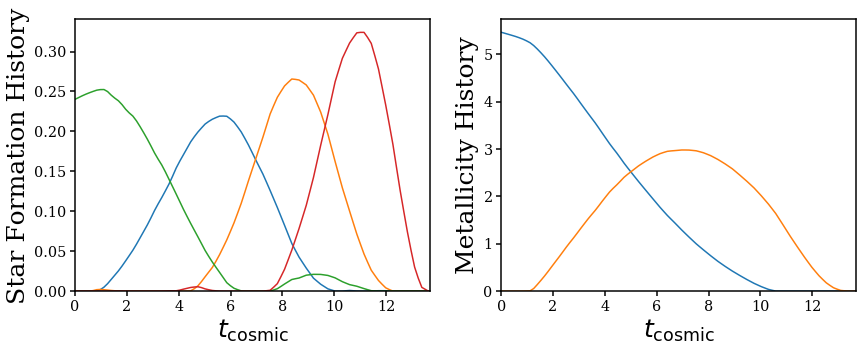

In [6]:
fig = plt.figure(figsize=(14, 5))
sub = fig.add_subplot(121)
for i in range(4): 
    _tt = np.zeros(10)
    _tt[i+1] = 1. 
    t, sfh = fsps_emulator.SFH(_tt, 0.)
    sub.plot(t, sfh)
sub.set_xlabel(r'$t_{\rm cosmic}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylabel('Star Formation History', fontsize=25)
sub.set_ylim(0., None)

sub = fig.add_subplot(122)
for i in range(2): 
    _tt = np.zeros(10)
    _tt[i+5] = 1. 
    t, zh = fsps_emulator.ZH(_tt, 0.)
    sub.plot(t, zh)
sub.set_xlabel(r'$t_{\rm cosmic}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylabel('Metallicity History', fontsize=25)
sub.set_ylim(0., None)

Since the basis functions are fixed, the free parameters of the SPS model that determine the SFH and ZH are the 4 coefficients for the SFH basis functions and the 2 coefficients for the ZH basis functions

# Flexible Stellar Population Synthesis (FSPS)
Now that we understand all the pieces, lets generate some spectra. To actually generate the CSP spectrum, we use the package [`FSPS`](https://github.com/cconroy20/fsps) and the python wrapper for it [`python-fsps`](https://github.com/dfm/python-fsps). These packages have impleneted SSPs and dust models, which make it easy to calculate CSPs by providing SFH and ZH. Our fiducial model takes in the following parameters: 
1. log M*: log stellar mass
2. b1^SFH: coefficient of first SFH basis function
3. b2^SFH: coefficient of second SFH basis function
4. b3^SFH: coefficient of third SFH basis function
5. b4^SFH: coefficient of fourth SFH basis function
6. g1^ZH: coefficient of first ZH basis function
7. g2^ZH: coefficient of second ZH basis function
8. dust1: Dust parameter describing the attenuation of young stellar light
9. dust2: Dust parameter describing the attenuation of old stellar light
10. dust_index:  Power law index of the attenuation curve

Installing FSPS on NERSC is a bit of a pain so we won't bother in this tutorial. See https://github.com/changhoonhahn/gqp_mc#installing-fsps for instructions on how to install FSPS on NERSC. 

# emulating FSPS --- `DESISpeculator`
In order to fit galaxy spectra, we'll need to run the SPS model a bunch of times for each spectra. If we want to sample the posterior, we'll need to run the SPS model >>10,000 times. FSPS takes a couple second to generate each CSP spectrum --- this is way too long. 

Instead, James (Kyubin) Kwon and I trained an emulator that takes in the same parameters and returns the FSPS output to <1% level accuracy. The emulator is a fully connected neural network that takes in the parameters above and predicts the PCA coefficients for a set of fixed PCA spectral bases. See [Alsing et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJS..249....5A/abstract) for details. 

Here's how well the emulator (black dashed) reproduces some random SSPs generated from FSPS (colors): 

<img src="ssp.png" width=600>

You can hardly tell the difference. 

With the `provabgs` package, calling the SPS model and generating the CSP spectrum for a set of parameters is very straightforward: 
```python
wave, flux = fsps_emulator.sed(
    np.array([10., 0.25, 0.25, 0.25, 0.25, 1.e-4, 1.e-4, 0., 0., -1]), # some arbitrary set of parameter values
    0.1 # some random redshift
)
```

In [7]:
wave, flux = fsps_emulator.sed(
    np.array([10., 0.25, 0.25, 0.25, 0.25, 1.e-4, 1.e-4, 0., 0., -1]), # some arbitrary set of parameter values
    0.1 # z= 0.1
)

(0, 75)

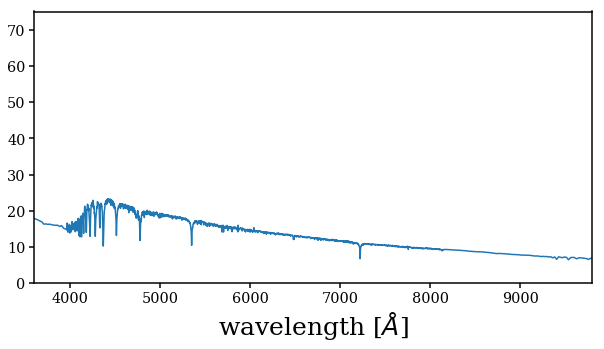

In [8]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(wave, flux)
sub.set_xlabel('wavelength [$\AA$]', fontsize=25)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(0, 75)

We can generate some more arbitrary CSP spectra by sampling the prior. `provabgs` has a convenient way to set priors in the `provabgs.infer` module. To define a prior, load in a set of prior objects (e.g. `UniformPrior` or `FlatDirichletPrior`)

In [9]:
from provabgs import infer as Infer
priors = Infer.load_priors([
        Infer.UniformPrior(10., 10.5, label='sed'),
        Infer.FlatDirichletPrior(4, label='sed'), 
        Infer.UniformPrior(np.array([6.9e-5, 6.9e-5, 0., 0., -2.2]), np.array([7.3e-3, 7.3e-3, 3., 4., 0.4]), label='sed')
    ])

Then we can sample this prior and generate their spectra! 

In [10]:
random_thetas = [priors.sample() for i in range(5)]

(0, 10.486660164991115)

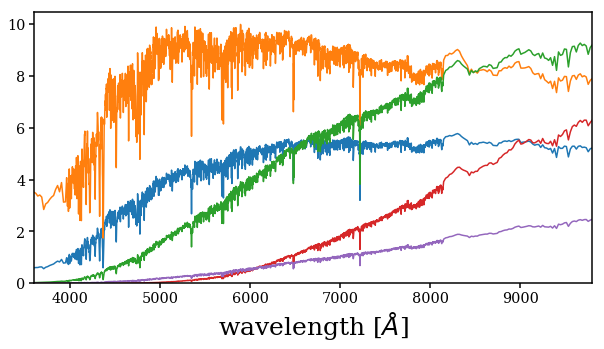

In [11]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for tt in random_thetas: 
    wave, flux = fsps_emulator.sed(priors.transform(tt), 0.1)
    sub.plot(wave, flux)
sub.set_xlabel('wavelength [$\AA$]', fontsize=25)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(0, None)

Note that we transform the parameters before we input them into the SPS model with `priors.transform`. This step is necessary because we set Dirichlet priors for the SFH basis coefficients. To sample the Dirichlet prior, we first sample a uniform distribution then use a warped manifold transformation to transform.

# Fitting galaxy spectra using SPS models
Now that we know how to call the model, lets try fitting some actual DESI spectra! We'll read in the same BGS spectra from CMX. 

In [12]:
from desispec.io import read_spectra
spectra = read_spectra('coadd-66003-20200315-1-00055654.few.fits') # handful of BGS galaxies from Tile 66003 observed on 03/15/2020, Petal #1, Exposure #00055654
igal = 3 # I like this one

(3600.0, 9800.0)

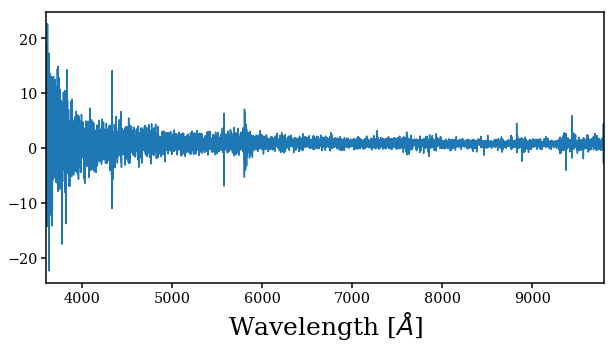

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spectra.wave['brz'], spectra.flux['brz'][igal])
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim(3.6e3, 9.8e3)

In [14]:
from astropy.table import Table
zbest = Table.read('zbest.coadd.fits', hdu=1)
zred = zbest['Z'][igal]

To fit the spectrum, we want to maximize the posterior --- probability of the model given the data. Below is a function for calculating the log posterior using Bayes theorm.

In [15]:
def lnPost(theta): 
    # calculate log prior
    lp = priors.lnPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ttheta = priors.transform(theta) 

    # calculate SED model(theta) 
    _, flux = fsps_emulator.sed(ttheta, zred, wavelength=spectra.wave['brz'])
    
    # data - model(theta)
    dflux = (flux - spectra.flux['brz'][igal]) 
    
    # chi-squared
    chi2 = np.sum(dflux**2 * spectra.ivar['brz'][igal]) 
    
    lnLike = -0.5 * chi2
    return lp + lnLike

Now lets maximize the log posterior (or minimize -1 * log posterior)

In [16]:
import scipy.optimize as op

x0 = np.median([priors.sample() for i in range(10)], axis=0)
print(x0)
_lnpost = lambda *args: -2. * lnPost(*args) 
min_result = op.minimize(
    _lnpost, 
    tt, 
    method='Nelder-Mead',                
    options={'maxiter': 5000}) 

[ 1.02162477e+01  4.44626951e-01  5.43401721e-01  3.85242799e-01
  4.15358570e-03  3.05104834e-03  2.23610306e+00  1.87380068e+00
 -1.03368193e+00]


In [17]:
theta_bestfit = priors.transform(min_result['x'])
_, flux_bestfit = fsps_emulator.sed(theta_bestfit, zred, wavelength=spectra.wave['brz'])

(0.0, 5)

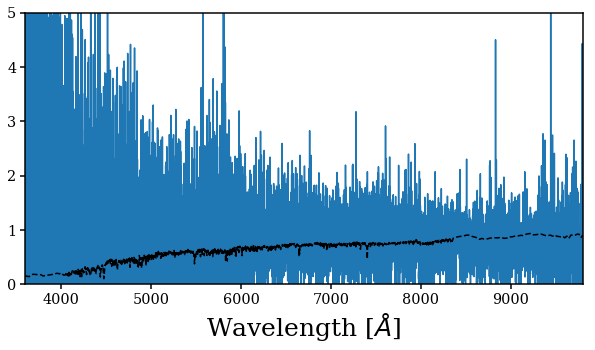

In [18]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spectra.wave['brz'], spectra.flux['brz'][igal])
sub.plot(spectra.wave['brz'], flux_bestfit.flatten(), c='k', ls='--')
sub.set_xlabel('Wavelength [$\AA$]', fontsize=25)
sub.set_xlim(3.6e3, 9.8e3)
sub.set_ylim(0., 5)

nice. The model looks pretty good.

The best-fit model has

In [19]:
print('log(stellar mass) = %.2f' % theta_bestfit[0])

log(stellar mass) = 10.00


In [20]:
tage, sfh = fsps_emulator.SFH(theta_bestfit, zred=zred)
_, zh = fsps_emulator.ZH(theta_bestfit, zred=zred)

and the following SFH and ZH

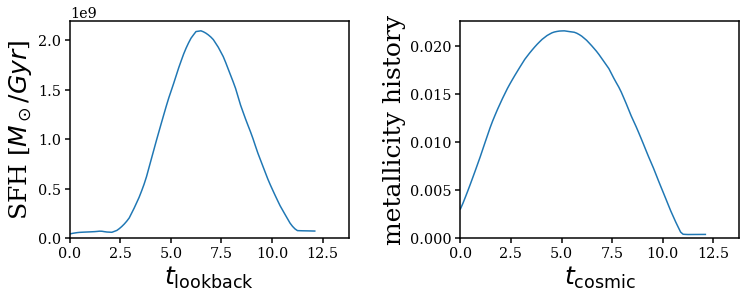

In [21]:
tlookback = tage[-1] - tage

fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(121)
sub.plot(tlookback, sfh)
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0, fsps_emulator.cosmo.age(0.).value)
sub.set_ylabel('SFH [$M_\odot/Gyr$]', fontsize=25)
sub.set_ylim(0, None)

sub = fig.add_subplot(122)
sub.plot(tlookback, zh)
sub.set_xlabel(r'$t_{\rm cosmic}$', fontsize=25)
sub.set_xlim(0, fsps_emulator.cosmo.age(0.).value)
sub.set_ylabel('metallicity history', fontsize=25)
sub.set_ylim(0, None)

fig.subplots_adjust(wspace=0.4)

We can go beyond optimizing the posterior and actually sample the posterior with Markov Chain Monte Carlo (MCMC). Thanks to the emulator, we can actually do this pretty quickly! 

`provabgs.infer` has MCMC objects, which can be used to easily run MCMC. In our case, you just have to provide the prior, the data, and a few choices for the MCMC. 

In [39]:
desi_mcmc = Infer.desiMCMC(prior=priors, model=fsps_emulator)

In [40]:
mcmc = desi_mcmc.run(
    wave_obs=spectra.wave['brz'],
    flux_obs=spectra.flux['brz'][igal],
    flux_ivar_obs=spectra.ivar['brz'][igal],
    zred=zred, 
    sampler='zeus',
    nwalkers=100, 
    burnin=100,
    opt_maxiter=10000,
    niter=1000, 
    debug=True)

--- initializing the walkers ---


Initialising ensemble of 100 walkers...


initial theta = [10.499999861350435, 0.9999999445044565, 0.6484930017795767, 0.6844632542813275, 0.001087983937821793, 0.0030788084171426136, 2.3447322318608586, 0.39344402896820097, -1.0151382773692883]
log Posterior(theta0) = -4753.177912
--- running MCMC ---


Sampling progress :   4%|▍         | 45/1100 [04:37<1:35:38,  5.44s/it]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(mcmc['mcmc_chain'][:,:,0])
plt.xlim(0, 1000)

Now with the chain we can look at the posterior for the SFH and ZH!

In [ ]:
markov_chain = desi_mcmc._flatten_chain(mcmc['mcmc_chain'])

In [ ]:
sfhs, zhs = [], [] 
for tt in markov_chain[-10000:]:
    _, _sfh = fsps_emulator.SFH(tt, zred)
    _, _zh = fsps_emulator.ZH(tt, zred)
    sfhs.append(_sfh)
    zhs.append(_zh)

In [ ]:
sfh_q = np.quantile(sfhs, [0.16, 0.50, 0.84], axis=0)
zh_q = np.quantile(zhs, [0.16, 0.5, 0.84], axis=0)

fig = plt.figure(figsize=(12,4))
sub = fig.add_subplot(121)
sub.fill_between(tlookback, sfh_q[0], sfh_q[2], alpha=0.5)
sub.plot(tlookback, sfh_q[1])
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0, fsps_emulator.cosmo.age(0.).value)
sub.set_ylabel('SFH [$M_\odot/Gyr$]', fontsize=25)
sub.set_ylim(0, None)

sub = fig.add_subplot(122)
sub.fill_between(tlookback, zh_q[0], zh_q[2], alpha=0.5)
sub.plot(tlookback, zh_q[1])
sub.set_xlabel(r'$t_{\rm cosmic}$', fontsize=25)
sub.set_xlim(0, fsps_emulator.cosmo.age(0.).value)
sub.set_ylabel('metallicity history', fontsize=25)
sub.set_ylim(0, None)

fig.subplots_adjust(wspace=0.4)